# Исследования корректности методов для 2D уравнений мелкой воды

In [35]:
%load_ext autoreload
%autoreload 2

from state import State
from domain import Domain
from swe_operators import SweLinearOperator, SweAdvectiveFormOperator, SweVecInvFormOperator, SweAdvectionOnlyFormOperator
from time_schemes import rk4
from initial_conditions import gaussian_hill, barotropic_instability, gaussian_hill_linexy, gaussian_hill_linex, gaussian_hill_liney
import operators as op
from vizualization import surf_field, imshow_field
from vizualization import animate_imshow, animate_surf, surf_field

import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
# definition of computational domain constants
RADZ = 6371.22 * 1000.0 # "Earth" radii in meters
GRAV = 9.80616 # "Earth" gravity acceleration in m * s**(-2)
OMEGA = 7.292 * 10**(-5) # "Earth" angular velocity in rad * s**(-1)
PCORI = 2 * OMEGA # Coriolis parameter
H_MEAN = 10 * 1000.0 # "Earth" mean atmosphere depth
C_GRAV = np.sqrt(GRAV * H_MEAN) # Gravity wave speed
LX = 2 # domain size [0, LX] x [0, LY]
LY = 2 # domain size [0, LX] x [0, LY]

-------

In [46]:
%%time
import time
from IPython.display import display, clear_output

N = 3
errorsl2   = np.zeros(N)
errorslinf = np.zeros(N)
h_array    = np.zeros(N)

T = 2
swe_operator = SweAdvectionOnlyFormOperator(g = GRAV, pcori = PCORI, diff_method = op.central_diff2)

for i in range(N):
    domain = Domain(xs = 0.0, xe = LX, nx = 128 * (i + 1), ys = 0.0, ye = LY, ny = 128 * (i + 1))
    state = gaussian_hill_linex(domain, H_MEAN, k_u = 1)
    swe_operator = SweAdvectionOnlyFormOperator(g = GRAV, pcori = PCORI, diff_method = op.upstream1)
    Nt = 128 * 2 * (i + 1)
    dt = T / Nt

    states_list = [state]
    for k in range(Nt+1):
        clear_output(wait=True)
        display('Time step '+str(k))
        state = rk4(state, swe_operator, dt, domain)
        states_list.append(state)
        
    h_list = [state.h for state in states_list]
    vect = h_list[-1] - h_list[0]
    for j in range(128 * (i + 1) + 1):
        for p in range(128 * (i + 1) + 1):
            errorsl2[i] += vect[i,j]**2
            
    errorsl2[i] = np.sqrt(errorsl2[i]/(128 * (i + 1)))
    errorslinf[i] = np.amax(abs(vect))
            
    h_array[i] = LX / (128 * (i + 1))

'Time step 768'

CPU times: user 16min 56s, sys: 7.09 s, total: 17min 3s
Wall time: 17min 8s


<IPython.core.display.Javascript object>


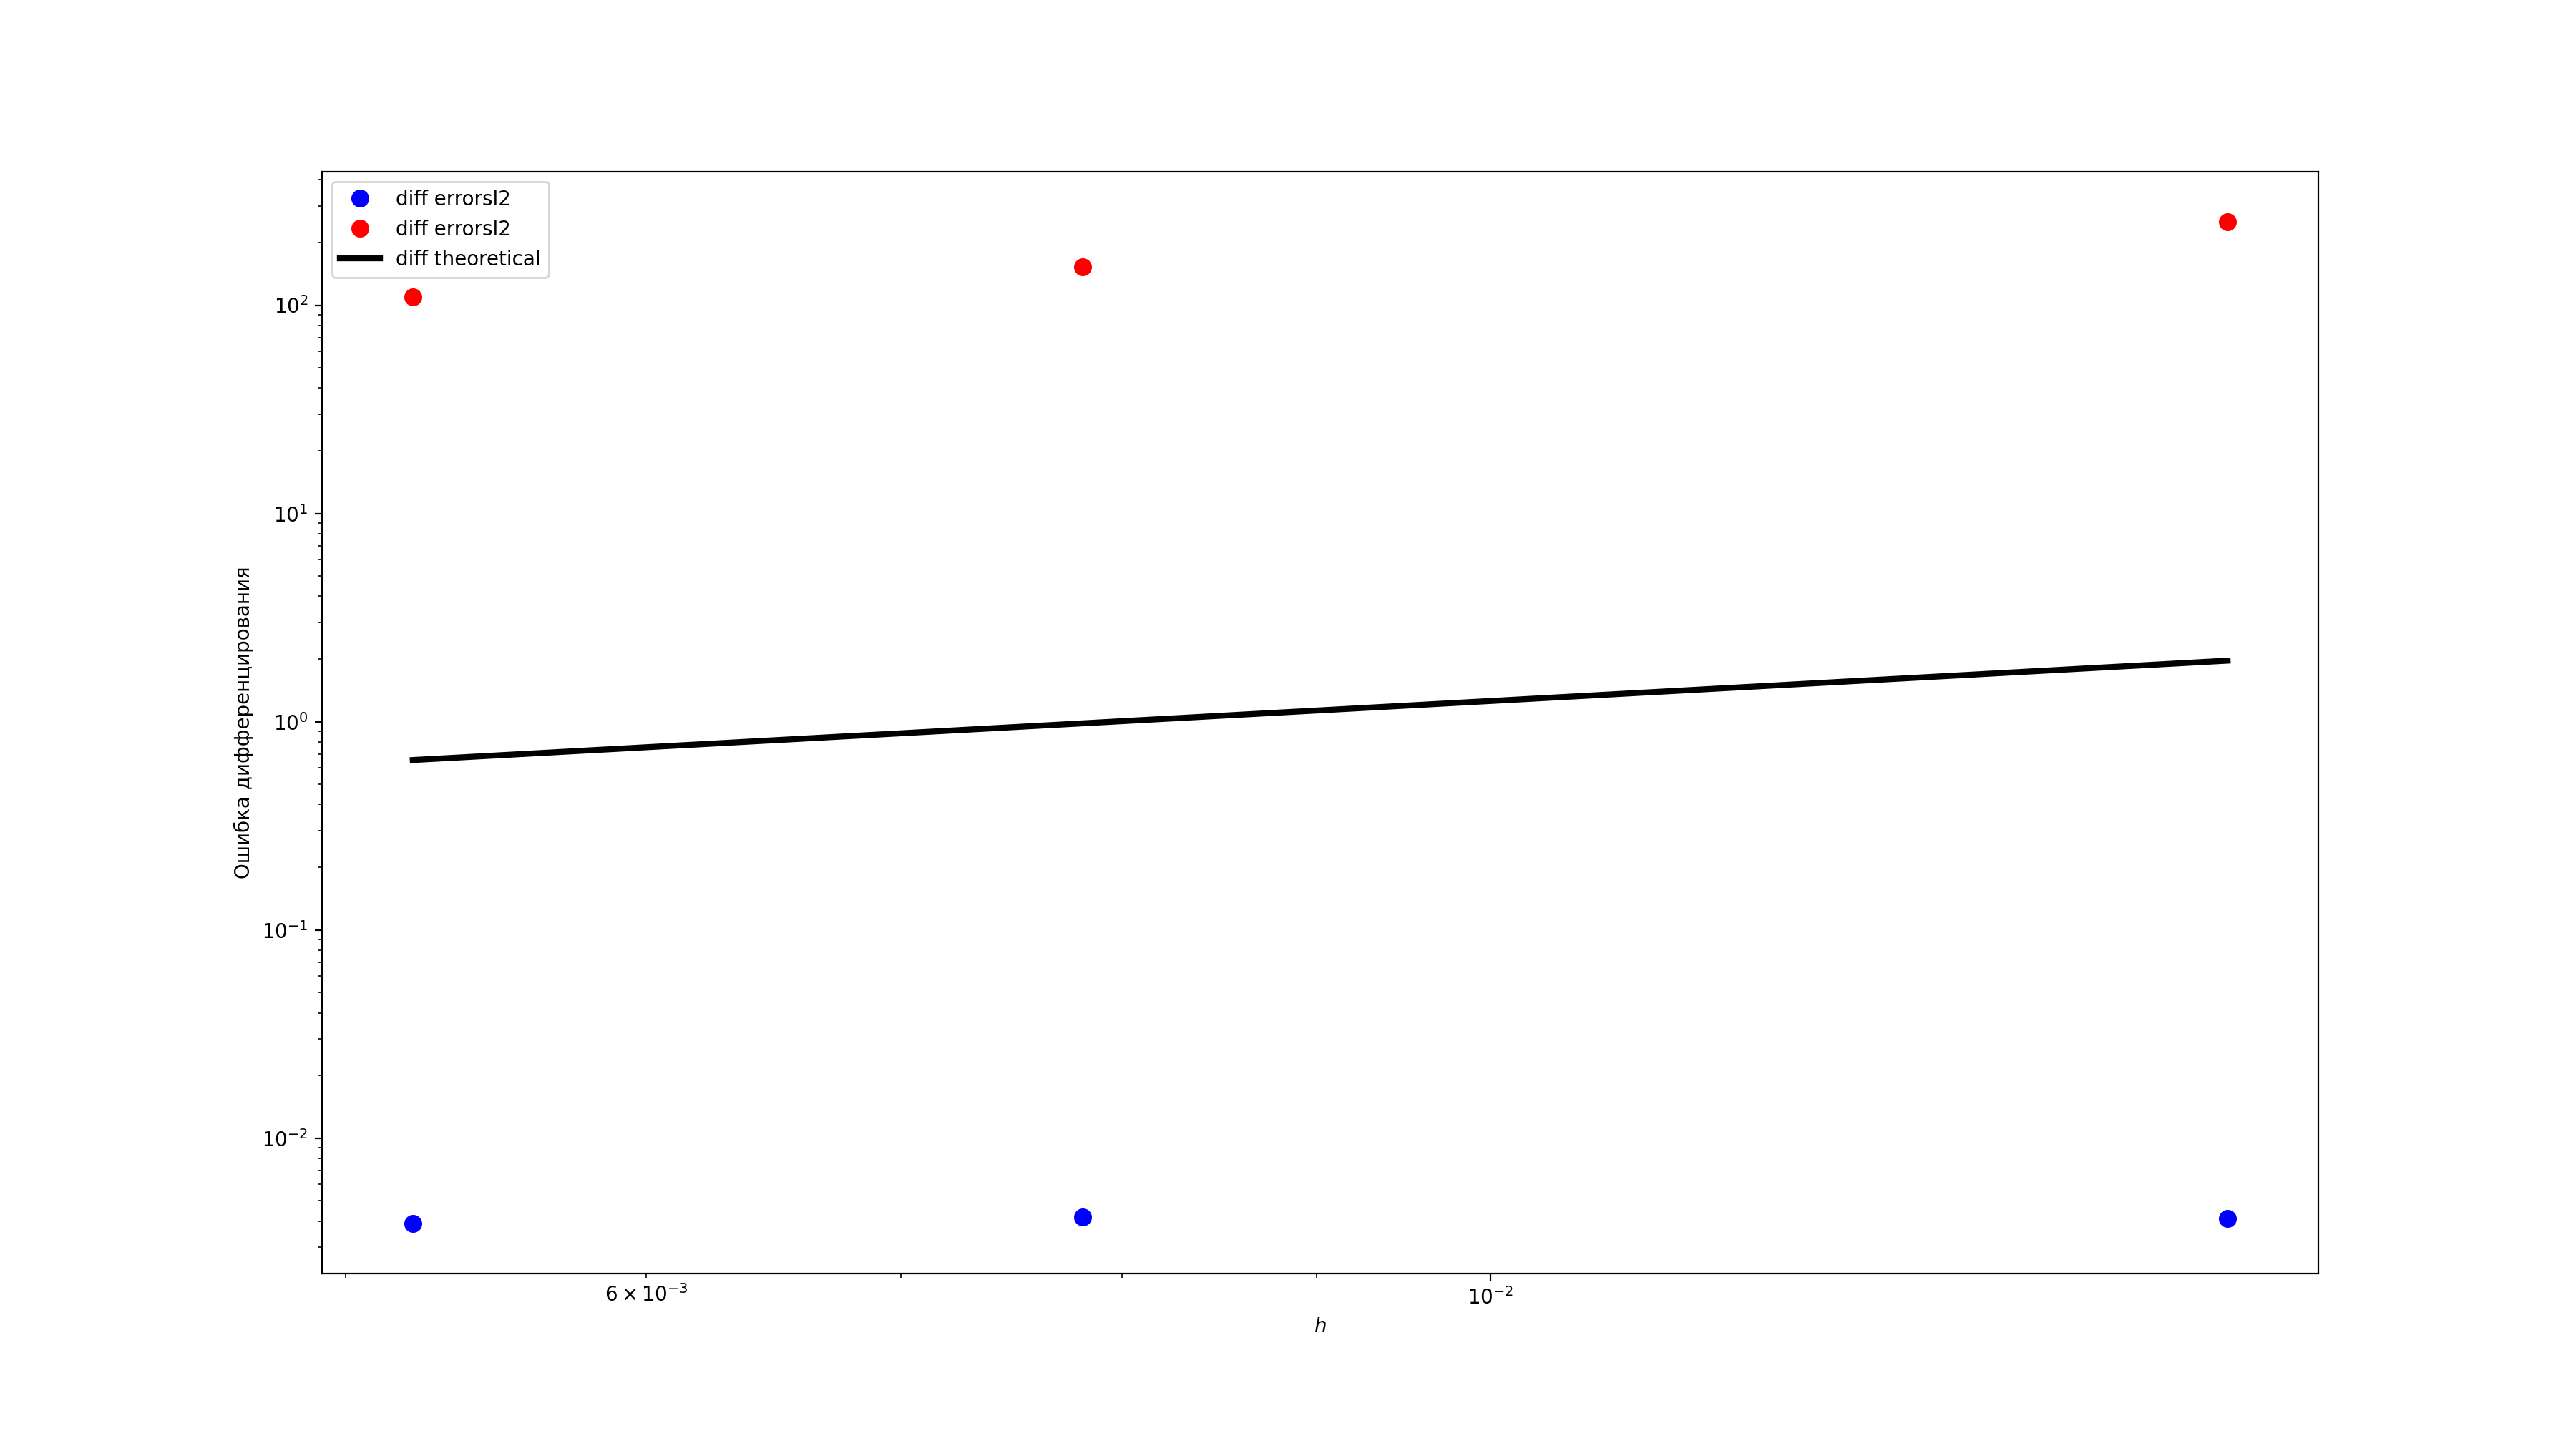

In [48]:
plt.figure(figsize=(18, 10))
plt.loglog(h_array, errorsl2, 'b.', ms=16, label='diff errorsl2')
plt.loglog(h_array, errorslinf, 'r.', ms=16, label='diff errorsl2')
plt.loglog(h_array, (errorsl2[0] + errorslinf[0])/2*h_array, 'k-', label='diff theoretical', lw=3)
plt.xlabel('$h$')
plt.ylabel('Ошибка дифференцирования')
plt.legend()
plt.show()

In [49]:
%%time
import time
from IPython.display import display, clear_output

N = 3
errorsl2   = np.zeros(N)
errorslinf = np.zeros(N)
h_array    = np.zeros(N)

T = 2
swe_operator = SweAdvectionOnlyFormOperator(g = GRAV, pcori = PCORI, diff_method = op.central_diff2)

for i in range(N):
    domain = Domain(xs = 0.0, xe = LX, nx = 128 * (i + 1), ys = 0.0, ye = LY, ny = 128 * (i + 1))
    state = gaussian_hill_linex(domain, H_MEAN, k_u = 1)
    swe_operator = SweAdvectionOnlyFormOperator(g = GRAV, pcori = PCORI, diff_method = op.diff_sbp21)
    Nt = 128 * 2 * (i + 1)
    dt = T / Nt

    states_list = [state]
    for k in range(Nt+1):
        clear_output(wait=True)
        display('Time step '+str(k))
        state = rk4(state, swe_operator, dt, domain)
        states_list.append(state)
        
    h_list = [state.h for state in states_list]
    vect = h_list[-1] - h_list[0]
    for j in range(128 * (i + 1) + 1):
        for p in range(128 * (i + 1) + 1):
            errorsl2[i] += vect[i,j]**2
            
    errorsl2[i] = np.sqrt(errorsl2[i]/(128 * (i + 1)))
    errorslinf[i] = np.amax(abs(vect))
            
    h_array[i] = LX / (128 * (i + 1))

'Time step 768'

CPU times: user 31.4 s, sys: 5.17 s, total: 36.6 s
Wall time: 35.9 s


<IPython.core.display.Javascript object>


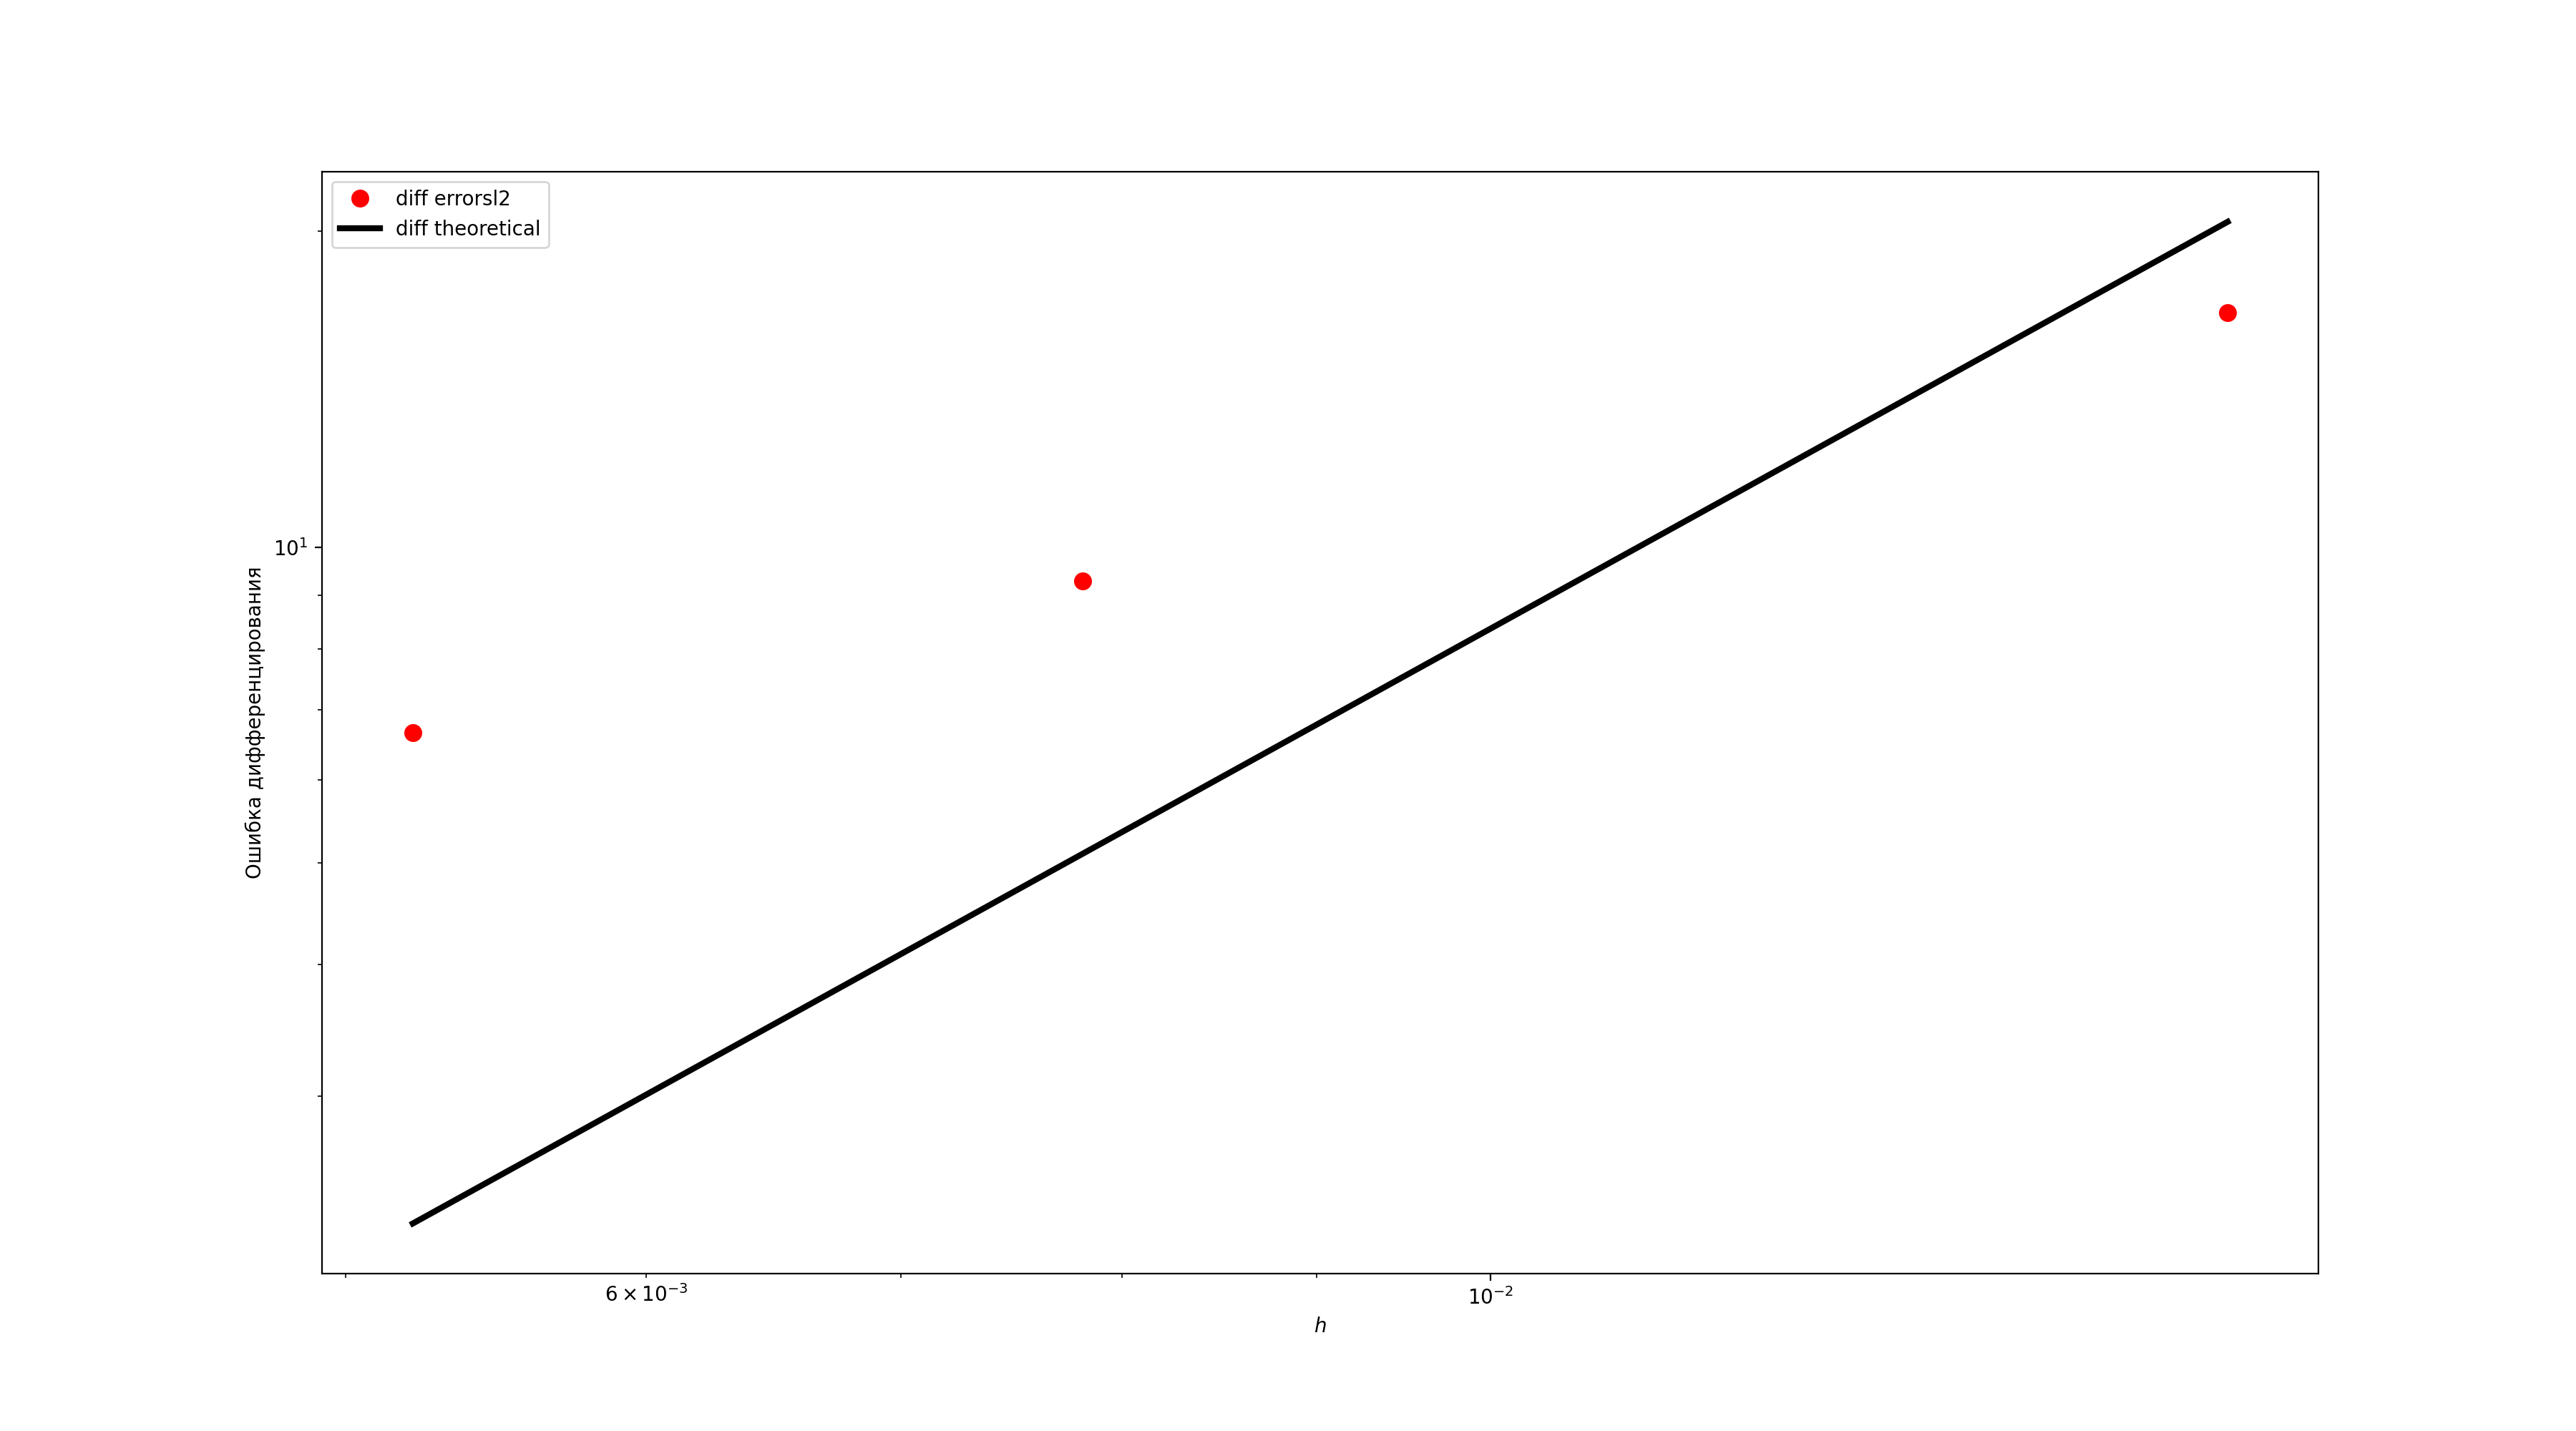

In [54]:
plt.figure(figsize=(18, 10))
plt.loglog(h_array, errorslinf, 'r.', ms=16, label='diff errorsl2')
plt.loglog(h_array, 10000*(errorsl2[0] + errorslinf[0])/2*h_array**2, 'k-', label='diff theoretical', lw=3)
plt.xlabel('$h$')
plt.ylabel('Ошибка дифференцирования')
plt.legend()
plt.show()